In [57]:
import torch
import numpy as np
import json
import transformers
import matplotlib.pyplot as plt
import IPython

from math import ceil

from IPython.display import clear_output
from tqdm.auto import tqdm

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, pipeline, DistilBertForSequenceClassification, DistilBertConfig
from sklearn.model_selection import train_test_split

## Берем данные

In [2]:
# import kagglehub
# import shutil

# # Download latest version
# path = kagglehub.dataset_download("neelshah18/arxivdataset")

# print("Path to dataset files:", path)
# shutil.move(path, '/home/mosievich.kirill/ysda/ml_3/data')

In [3]:
import json
file = open('/home/mosievich.kirill/ysda/ml_3/data/2/arxivData.json')
data = json.load(file)

In [4]:
def trl(container):
    return tqdm(range(len(container)))

def prepared(string):
    string = string.replace("'", '"')
    string = string.replace('None', 'null')
    return string

In [5]:
titles = [data[i]['title'] for i in trl(data)]
summaries = [data[i]['summary'] for i in trl(data)]
tags = [[json.loads(prepared(data[i]['tag']))[j]['term'] for j in range(len(json.loads(prepared(data[i]['tag']))))] for i in trl(data)]

  0%|          | 0/41000 [00:00<?, ?it/s]

  0%|          | 0/41000 [00:00<?, ?it/s]

  0%|          | 0/41000 [00:00<?, ?it/s]

In [6]:
tags[200:210]

[['cs.LG', 'cs.AI', 'cs.CV', 'cs.NE'],
 ['cs.CV', 'cs.AI', 'cs.LG', 'cs.NE', '68T05, 68T45', 'I.2.6; I.4.6; I.5.5'],
 ['cs.LG', 'cs.AI', 'cs.CV', 'cs.NE'],
 ['cs.LG', 'cs.AI', 'cs.CV', 'cs.NE'],
 ['cs.LG', 'cs.CV', 'cs.NE', 'stat.ML'],
 ['stat.ML', 'cs.CV', 'cs.LG', 'cs.NE'],
 ['stat.ML', 'cs.CV', 'cs.LG', 'cs.NE'],
 ['cs.CV', 'cs.LG', 'cs.NE', 'stat.ML'],
 ['stat.ML', 'cs.CV', 'cs.LG', 'cs.NE'],
 ['cs.NE', 'cs.CV', 'cs.LG', 'stat.ML']]

## Какие вообще есть классы и сколько их эту инфу хочется сохранить и загружать потом

In [7]:
import requests
page = requests.get("https://arxiv.org/category_taxonomy")

In [8]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')

In [9]:
h4_cases = soup.find_all('h4')

In [10]:
tags_tags = h4_cases[1:]
possible_tags = set()
tag_to_id = {}
id_to_tag = {}
id_to_description = {}
for i, html_tag in enumerate(tags_tags):
    idx = html_tag.get_text().find(' ')
    tag = html_tag.get_text()[:idx]
    description = html_tag.get_text()[idx+2:-1]
    possible_tags.add(tag)
    tag_to_id[tag] = i
    id_to_tag[i] = tag
    id_to_description[i] = description

In [11]:
num_tags = len(possible_tags)

In [12]:
len(possible_tags)

155

In [13]:
with open('tags.txt', 'w') as file:
    for i in range(num_tags):
        file.write(str(id_to_tag[i]) + ' ' + str(id_to_description[i]) + '\n')

In [14]:
for i, line in enumerate(tags):
    line = list(set(line) & possible_tags)
    int_line = []
    for tag in line:
        int_line.append(tag_to_id[tag])
    tags[i] = int_line

## Разделение данных на train test и подготовка батчей

In [28]:
titles_train, titles_test, summaries_train, summaries_test, tags_train, tags_test = train_test_split(titles, summaries, tags, test_size=0.1, random_state=42)

In [29]:
base_model_name = 'distilbert-base-uncased'
base_tokenizer = AutoTokenizer.from_pretrained(base_model_name)
#base_model = AutoModel.from_pretrained(base_model_name).to('cuda')

In [30]:
def multi_hot(indexes, num_classes):
    return torch.zeros((num_classes,)).scatter_(0, torch.tensor(indexes), torch.ones((num_classes,)))

In [31]:
class ArXivDataset(Dataset):
    def __init__(self, titles, abstracts, tags, possible_tags, tokenizer):
        super(ArXivDataset, self).__init__()
        self.titles = titles
        self.abstracts = abstracts
        self.tags = tags
        self.possible_tags = possible_tags
        self.num_classes = len(self.possible_tags)
        self.tokenizer = tokenizer
        
        self.inputs = ['Title: ' + self.titles[idx] + ' Abstract: ' + self.abstracts[idx] for idx in range(len(titles))]
        self.inputs = self.tokenizer(self.inputs, truncation=True, padding='max_length', max_length=512, return_tensors='pt')['input_ids']
    
    def __len__(self):
        return len(self.titles)
    
    def __getitem__(self, idx):
        return (self.inputs[idx], multi_hot(self.tags[idx], self.num_classes) / len(self.tags[idx]))

In [32]:
base_train_ds = ArXivDataset(titles_train, summaries_train, tags_train, possible_tags, base_tokenizer)
base_test_ds = ArXivDataset(titles_test, summaries_test, tags_test, possible_tags, base_tokenizer)

base_train_dl = DataLoader(base_train_ds, shuffle=True, 
    batch_size=128, num_workers=0)
base_test_dl = DataLoader(base_test_ds, shuffle=True, 
    batch_size=128, num_workers=0)

small_ds = ArXivDataset(titles_train, summaries_train, tags_train, possible_tags, base_tokenizer)
small_dl = DataLoader(small_ds, shuffle=True, 
    batch_size=128, num_workers=0)

## Токенизация

In [33]:
#tokens_info = tokenizer(x, padding=True, truncation=True, return_tensors="pt")

In [34]:
#print(tokens_info)

In [35]:
#for i in range(2):
#    print(tokenizer.decode(tokens_info['input_ids'][i]))
# тестик того что выведет

## Модель классификации

In [36]:
classifier = DistilBertForSequenceClassification.from_pretrained(base_model_name, num_labels=num_tags).to('cuda')
for param in classifier.base_model.parameters():
    param.requires_grad = False

classifier.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [37]:
#tokens_info['input_ids'].shape

In [38]:

## тестики
# #for param in model.parameters():
# #    param.requires_grad = False
    
# ## !!!
# final_model = nn.Sequential(
#     tokenizer,
#     model
# )
# ####

# for param in final_model.parameters():
#     param.requires_grad = False

# final_model.second.classifier = nn.Sequential(
#     torch.nn.Linear(20, 30),
# )

# model

# model.classifier = torch.nn.Identity()

# with torch.no_grad():
#     kk= tokens_info['input_ids'][:2]
#     ans = model(tokens_info['input_ids'][:2])

# ans.logits.shape

#DataLoader(data, batch_size=batch_size, shuffle=(num_samples is None))

In [39]:
# for epoch in range(100):
#     gd.zero_grad()
#     loss = batch_loss(batch)
#     if maximization:
#         (-loss).backward()
#     else:
#         loss.backward()
#     gd.step()

## Проедура для обучения, валидации и отрисовки графиков

In [40]:
def plot_learning_process(train_loss, val_loss):    
    plt.figure()
    plt.plot(np.arange(0, len(val_loss)) + 0.5, train_loss, label='train')
    plt.plot(np.arange(0, len(val_loss)) + 1, val_loss, label='val')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.show()

In [43]:
def train_loop(model, dataloader, loss_fn, optimizer, step=0.05, history_loss=None):
    out_display = display(IPython.display.Pretty('Traininf'), display_id=True)
    
    size = len(dataloader.dataset) 
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1
        
    train_loss = []
    percentage = 0
    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch: ")):
        X, y = X.to(device), y.to(device)

        output = F.softmax(model(X).logits, dim=1)
        loss = loss_fn(output, y)
        train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        if batch / batches > percentage or batch == batches: 
            out_display.update(f'Steps: {int(percentage * size)} / {size} | Loss: {train_loss[-1]}')
            percentage += step
        
    if history_loss is not None:
        history_loss.append(np.mean(train_loss))

    return {'train_loss': np.mean(train_loss)}
        
def test_loop(model, dataloader, loss_fn, history_loss=None, history_acc=None):

    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    batches = ceil(size / dataloader.batch_size)

    val_loss = []
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc='Batch: ')):
            X, y = X.to(device), y.to(device)
            output = F.softmax(model(X).logits, dim=1)
            loss = loss_fn(output, y)
            test_loss += loss.item()
                
            val_loss.append(loss.item())
            
    test_loss /= batches
    correct /= size
    
    print(f"Validation accuracy: {100 * correct}, Validation loss: {test_loss} \n")
    
    if history_loss is not None:
        history_loss.append(np.mean(val_loss))
    
    return {'val_loss': np.mean(val_loss)}

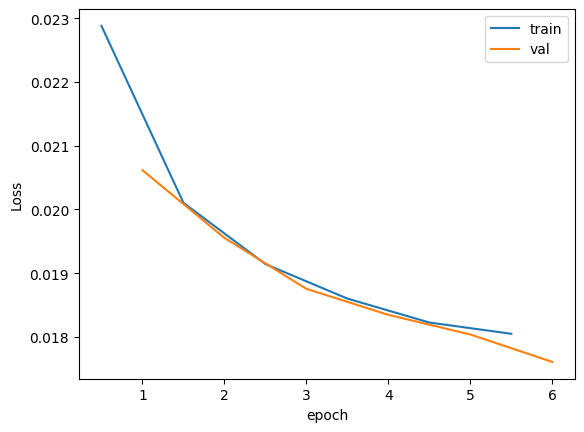

In [44]:
device = 'cuda'


loss_fn = F.binary_cross_entropy
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
epochs = 6

train_loss = []
val_loss = []
    
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    
    train_loop(classifier, base_train_dl, loss_fn, optimizer, history_loss=train_loss)
    test_loop(classifier, base_test_dl, loss_fn, history_loss=val_loss)
    
    clear_output()
    plot_learning_process(train_loss, val_loss)

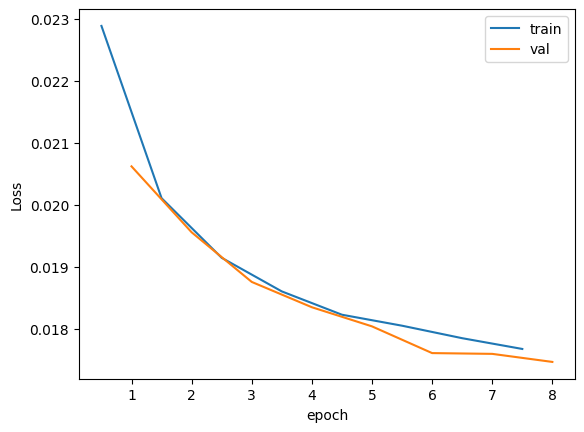

In [45]:
for epoch in range(2):
    print(f"Epoch: {epoch + 1}")
    
    train_loop(classifier, base_train_dl, loss_fn, optimizer, history_loss=train_loss)
    test_loop(classifier, base_test_dl, loss_fn, history_loss=val_loss)
    
    clear_output()
    plot_learning_process(train_loss, val_loss)

In [50]:
torch.save(classifier.state_dict(), 'pytorch_model_w.bin')

In [51]:
classifier.save_pretrained('my_model')

/tmp/ipykernel_42443/2240823436.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('YSDA_ML/pytorch_model.bin')


<All keys matched successfully>

## Что можно доделать?

- Взять более сильную модель 1b deepseek (у меня не завелся на hf c ходу, хотя время на обучения потратил, правда через lora adapter)
- Взять большую обучающую выборку | нагенерировать синтетику через ChatGPT/DeepSeek
- Большую модель можно квантизовать + спарсификация, что в терии поможет ее прогонять на мобильных устройствах
- Нормальный deploy: triton or vllm 

In [55]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("Cornell-University/arxiv",)

# print("Path to dataset files:", path)

In [57]:
# big_data = []
# with open('./data/226/arxiv-metadata-oai-snapshot.json') as big_file:
#     for line in tqdm(big_file):
#         big_data.append(json.loads(line))
#         if len(big_data) >= 10**5:
#             break

In [58]:
# titles = [big_data[i]['title'] for i in trl(big_data)]
# summaries = [big_data[i]['abstract'] for i in trl(big_data)]
# tags = [big_data[i]['categories'].split() for i in trl(big_data)]

In [59]:
# for i, line in enumerate(tags):
#     line = list(set(line) & possible_tags)
#     int_line = []
#     for tag in line:
#         int_line.append(tag_to_id[tag])
#     if len(int_line) == 0:
#         int_line.append(155)
#     tags[i] = int_line